# Relax Take Home Challenge

This is the notebook for the relax take home challenge. The project has two cvs files. One contains user information while the other contains the user log-in activities. The first task of this exercise is to indentify which user is considered "adopted user". A user is considered as an "adopted user" when that user logged into the products in three separates days within a week. The next task is to identify which factor predict future user adoption.

In [216]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from library.sb_utils import save_file
from datetime import timedelta
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

Let's first import that data that contains information of the user.

In [217]:
# Load the data. 
takehome_users = pd.read_csv('takehome_users.csv', encoding="latin1")

Let's take a closer look at the dataset.

In [218]:
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [219]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


There seems to be many missing null in the column "last_session_creation_time" and "invited_by_user_id". These features will probably won't tell us about which user is gonna adopted or not. Thus, we will drop these columns.

In [220]:
takehome_users.drop(columns=['last_session_creation_time','invited_by_user_id'],inplace=True)

Now, let's assign the user with the "adoption" status or not; and we will use the other dataset for it.

In [221]:
# Load the data. 
takehome_user_engagement=pd.read_csv('takehome_user_engagement.csv')

Let's take a look at this dataset.

In [222]:
takehome_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [223]:
takehome_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


The "time_stamp" column records the time when a user logged in. The "user_id" indicates the user. The "visited" column is a little strange so let's take a closer look at it.

In [224]:
takehome_user_engagement['visited'].value_counts()

1    207917
Name: visited, dtype: int64

It seems that the 'visited' column only has value 1 and does not contribute much. Thus, we will drop this column.

In [225]:
takehome_user_engagement.drop(columns='visited',inplace=True)

Next, let's change the type of the "time_stamp" column into datetime.

In [226]:
takehome_user_engagement['time_stamp'] = pd.to_datetime(takehome_user_engagement['time_stamp'])

In [227]:
takehome_users['org_id'].value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

In [228]:
takehome_user_engagement['time_stamp'] = pd.to_datetime(takehome_user_engagement['time_stamp'])

In [229]:
takehome_user_engagement.sort_values(["user_id", "time_stamp"])

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2
...,...,...
207912,2013-09-06 06:14:15,11996
207913,2013-01-15 18:28:37,11997
207914,2014-04-27 12:45:16,11998
207915,2012-06-02 11:55:59,11999


Now, we will assign the user's adoption status. For each time a user logged in, we will check in the next 7 days how many times a user logged in. If there are more then 2 log-in, we will check what days these log-in is in? And if there are more than 2 days, we will assign the user the adoption status. But first, we will create a column call "adopted_user" in the takehome_users dataset. Here, a user with adopted status will have value 1 and 0 otherwise.

In [230]:
takehome_users['adopted_user']=0

In [231]:
for i in takehome_user_engagement['user_id'].unique():
    temparray=takehome_user_engagement[takehome_user_engagement['user_id']==i]['time_stamp']
    lengtemp=len(temparray)
    if lengtemp>=3:
        usertoken=0
        j=0
        while usertoken==0:
            if len(temparray[(temparray>=temparray.iloc[j]) & (temparray<=temparray.iloc[j]+timedelta(days=7))].dt.day.unique())>=3:
                takehome_users.loc[takehome_users['object_id']==i,'adopted_user']=1
                usertoken=1
            j=j+1
            if j == lengtemp-2:
                usertoken=1
            

In [232]:
takehome_users['adopted_user'].value_counts()

0    10344
1     1656
Name: adopted_user, dtype: int64

Now, let's take a closer look at the dataset and see which feature affects the adopted_user status.

In [233]:
takehome_users.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,0


At first glance, it seems the features that might correlate to 'adopted_user' are: 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip' and 'org_id. The 'creation_source' contains categorial values so we need to do some dummy coding to it.

In [234]:
takehome_users = pd.get_dummies(takehome_users, columns = ['creation_source'])

takehome_users.head()

,object_id,creation_time,name,email,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1,0,11,0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,0,0,1,1,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,0,0,94,0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,0,0,1,0,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,0,0,193,0,1,0,0,0,0


Now, let's graph some of these values to see how they affect the adopted status.

Since most of these features are categorical, a great way to test their independences is the chi-square test. So let's try them

# Chi-Square Test for Categorical Features

In [235]:
features_cols = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id'
       , 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH']

In [236]:
for i in features_cols:
    print('The p value between adopted_user and '+i)
    contigency= pd.crosstab(takehome_users['adopted_user'], takehome_users[i])
    c, p, dof, expected = chi2_contingency(contigency)
    print(p)

The p value between adopted_user and opted_in_to_mailing_list
0.34847945597884034
The p value between adopted_user and enabled_for_marketing_drip
0.49429472330968593
The p value between adopted_user and org_id
3.155752101336821e-05
The p value between adopted_user and creation_source_GUEST_INVITE
1.4335009955909766e-06
The p value between adopted_user and creation_source_ORG_INVITE
0.487368060902751
The p value between adopted_user and creation_source_PERSONAL_PROJECTS
1.4615296030520491e-16
The p value between adopted_user and creation_source_SIGNUP
0.34605552188715294
The p value between adopted_user and creation_source_SIGNUP_GOOGLE_AUTH
8.713340325482517e-05


According to this, it seems there are strong correlation between the adapted_user with the creation_source and the org_id.

# histogram of org_id

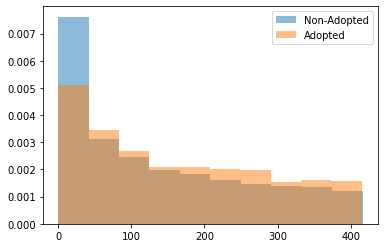

In [237]:
plt.hist(takehome_users[takehome_users['adopted_user']==0]['org_id'],density=True,alpha=0.5, label='Non-Adopted')
plt.hist(takehome_users[takehome_users['adopted_user']==1]['org_id'],density=True,alpha=0.5, label='Adopted')
plt.legend(loc='upper right')
plt.show()

The histogram indicates that proportionally many users in organization 1 are not adopted_user.

# Modeling

Let's try building a classification model to indicate "adopted_user".

In [238]:
X = takehome_users[features_cols]
y = takehome_users['adopted_user']


In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=332)

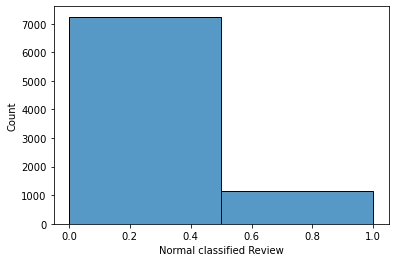

In [240]:
ax = sns.histplot(y_train, binwidth=0.5)
ax.set( xlabel='Normal classified Review')
plt.savefig("Classified_review_histogram_normal.png", bbox_inches="tight")
plt.show()

It seems there are many user who are not adopted then who are. We will have to oversample the adopted one for our model.

In [241]:
from sklearn.utils import resample
train_data = pd.concat([X_train, y_train], axis=1)
negative = train_data[train_data['adopted_user']==0]
positive = train_data[train_data['adopted_user']==1]
pos_oversampled = resample(positive,replace=True,n_samples=len(negative),random_state=21)
oversampled = pd.concat([negative, pos_oversampled])

In [242]:
y_train=oversampled.adopted_user
X_train=oversampled.drop(columns='adopted_user')

In [243]:

rf = RandomForestClassifier(bootstrap=True, class_weight= 'balanced', n_estimators=50,criterion='entropy')
rf.fit(X_train, y_train)

#Predict using the model:

y_predict_rf = rf.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)

[[2255  846]
 [ 369  130]]
0.6625


In [244]:
X.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [245]:
rf.feature_importances_

array([0.00813903, 0.00633044, 0.95529194, 0.00558874, 0.00319228,
       0.01589062, 0.00273321, 0.00283373])

8


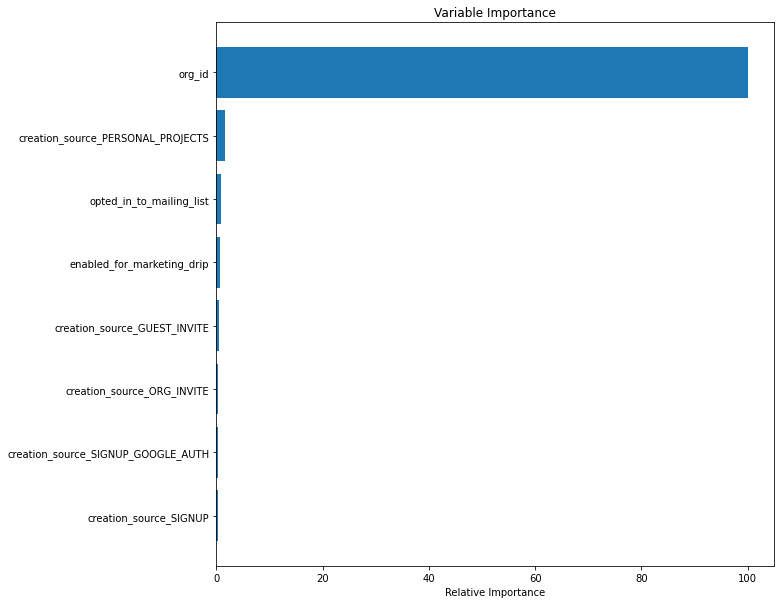

In [246]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Conclusion

Based on our analysis, it seems that the most important factors in indicating whether a user has the "adopted_user" status are "org_id" and "creation_source". "org_id" indicates the organization this user is on. And "creation_source" indicates how this user creates the accounts. For the "org_id", we can see from histograms that many people from org_id = 1 are not "adopted_user". 